In [113]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import requests
import os

pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 20)

## Fetch Data

### Standing

In [282]:
standings_ulrs = {
    "Serie A": "http://api.football-data.org/v4/competitions/SA/standings",
    "Bundesliga": "http://api.football-data.org/v4/competitions/BL1/standings",
    "La Liga": "http://api.football-data.org/v4/competitions/PD/standings"
}
headers = {"X-Auth-Token": os.getenv('footaball_data_token')}

In [283]:
standings = {}

for competition, url in standings_ulrs.items():
    response = requests.get(url, headers=headers)

    data = response.json()
    data = data['standings'][0]['table']
    standing = pd.DataFrame(data)

    # Extract the 'shortName' value from the 'team' dictionary
    standing['team_short_name'] = standing['team'].apply(lambda x: x['shortName'])
    # Drop the 'team' column
    standing.drop(columns=['team'], inplace=True)
    
    n_groups = 3
    standing['team_group'] = standing.position.apply(lambda x: int(((x-1)/(20/n_groups))))
    standing['team_short_name'] = standing['team_short_name'].replace({
                                                                'Spezia Calcio':'Spezia',
                                                                #
                                                                'Frankfurt':'Ein Frankfurt', 
                                                                '1. FC Köln': 'FC Koln',
                                                                'Hertha BSC': 'Hertha', 
                                                                'Bremen': 'Werder Bremen', 
                                                                'Schalke': 'Schalke 04', 
                                                                'Bayern': 'Bayern Munich',
                                                                #
                                                                'Barça':'Barcelona', 
                                                                'Cádiz CF': 'Cadiz', 
                                                                'Almería': 'Almeria', 
                                                                'Athletic':'Ath Bilbao', 
                                                                'Real Betis': 'Betis', 
                                                                'Espanyol': 'Espanol',
                                                                'Sevilla FC': 'Sevilla',
                                                                'Atleti': 'Ath Madrid', 
                                                                'Real Sociedad':'Sociedad', 
                                                                'Rayo Vallecano': 'Vallecano'
                                                                })

    standings[competition] = standing

### Results

In [284]:
data_url = {
    "Serie A": "https://www.football-data.co.uk/mmz4281/2223/I1.csv",
    "Bundesliga": "https://www.football-data.co.uk/mmz4281/2223/D1.csv",
    "La Liga": "https://www.football-data.co.uk/mmz4281/2223/SP1.csv"
}

data_paths = {
}

for competition, url in data_url.items():
    response = requests.get(url)
    filename = competition.replace(' ','_') + "_2022_2023.csv"
    file_path = f'data/raw/{filename}'

    with open(file_path, "wb") as f:
        f.write(response.content)
        
    df = pd.read_csv(file_path)
    df.loc[(df.HomeTeam == 'Empoli') & (df.AwayTeam == 'Cremonese'),'Date'] = '12/11/2022'
    df['year'] = pd.to_datetime(df.Date, format='%d/%m/%Y').dt.year
    df['month'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.month
    df['day'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.day
    df['week'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.isocalendar().week
    df['weekday'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.weekday
    
    df = df.sort_values(['year', 'month', 'day'])

    # Assign sequential week numbers to blocks of days from Thursday to Wednesday
    giornata = 1
    curr_day = (2020,1,1,-1,-1)
    infrasettimanale = False
    for i, row in df.iterrows():
        if row['week'] != curr_day[3] and abs(curr_day[4] - row['weekday']) < 6 and curr_day[4] > -1: 
            giornata += 1
        if row['week'] == curr_day[3] and abs(curr_day[4] - row['weekday']) > 1: 
            giornata += 1
        curr_day = (row['year'], row['month'], row['day'], row['week'], row['weekday'])
        df.at[i, 'giornata'] = giornata
    
    df.to_csv(f"data/clean/{filename}", index=False)
    data_paths[competition] = f"data/clean/{filename}"

## Configuration

In [434]:
competition = 'Serie A'
home_team = "Verona"
away_team = 'Sassuolo'

In [435]:
df = pd.read_csv(data_paths[competition], index_col=None)
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,year,month,day,week,weekday,giornata
0,I1,13/08/2022,17:30,Milan,Udinese,4,2,H,2,2,...,2.17,1.94,2.06,1.81,2022,8,13,32,5,1.0
1,I1,13/08/2022,17:30,Sampdoria,Atalanta,0,2,A,0,1,...,2.13,1.87,2.06,1.82,2022,8,13,32,5,1.0
2,I1,13/08/2022,19:45,Lecce,Inter,1,2,A,0,1,...,1.96,2.06,1.89,1.97,2022,8,13,32,5,1.0
3,I1,13/08/2022,19:45,Monza,Torino,1,2,A,0,1,...,1.88,2.16,1.83,2.06,2022,8,13,32,5,1.0
4,I1,14/08/2022,17:30,Fiorentina,Cremonese,3,2,H,2,1,...,2.07,1.97,1.99,1.87,2022,8,14,32,6,1.0


In [436]:
standing = standings[competition]
standing

,position,playedGames,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group
0,1,28,None,23,2,3,71,64,20,44,Napoli,0
1,2,28,None,16,7,5,55,44,19,25,Lazio,0
2,3,28,None,15,6,7,51,48,36,12,Milan,0
3,4,28,None,16,2,10,50,47,32,15,Inter,0
4,5,28,None,15,5,8,50,38,26,12,Roma,0
5,6,28,None,14,6,8,48,47,32,15,Atalanta,0
6,7,28,None,18,5,5,44,46,22,24,Juventus,0
7,8,28,None,11,7,10,40,36,36,0,Bologna,1
8,9,28,None,11,7,10,40,33,31,2,Fiorentina,1
9,10,28,None,10,8,10,38,30,34,-4,Torino,1


In [437]:
tt = df.merge(standing, left_on='HomeTeam', right_on='team_short_name', how='left')
assert len(tt[tt.team_group.isna()]) == 0, 'Some teams have no correpondence in standing'

## Data Preparations

In [438]:
def get_result(row):
    if(row['goal_fatti'] > row['goal_subiti']):
        return 'Win'
    if(row['goal_fatti'] == row['goal_subiti']):
        return 'Draw'
    return 'Loss'

In [439]:
df_match_home = df
df_match_home['main_team'] = df.HomeTeam
df_match_home['opponent_team'] = df.AwayTeam
df_match_home['goal_fatti'] = df['FTHG']
df_match_home['goal_subiti'] = df['FTAG']
df_match_home['tot_goals'] = df['goal_fatti'] + df['goal_subiti']
df_match_home['no_goal'] = (df['goal_fatti'] == 0) | (df['goal_subiti'] == 0)
df_match_home['goal'] = (df['goal_fatti'] != 0) & (df['goal_subiti'] != 0)
df_match_home['goal_no_goal'] = df_match_home['no_goal'].map({True: 'No Goal', False: 'Goal'})
df_match_home['type'] = 'home'
df_match_home['result'] = df_match_home.apply(get_result, axis=1)
df_match_home['team_has_scored'] = df_match_home['goal_fatti'] > 0
df_match_home['team_has_conceded_goal'] = df_match_home['goal_subiti'] > 0
df_match_home = df_match_home[['main_team','opponent_team','goal_fatti', 'no_goal', 'goal', 'tot_goals',\
                               'goal_subiti','type','result','team_has_scored','giornata','goal_no_goal',\
                              'team_has_conceded_goal']]

df_match_away = df
df_match_away['main_team'] = df.AwayTeam
df_match_away['opponent_team'] = df.HomeTeam
df_match_away['goal_fatti'] = df['FTAG']
df_match_away['goal_subiti'] = df['FTHG']
df_match_away['tot_goals'] = df['goal_fatti'] + df['goal_subiti']
df_match_away['type'] = 'away'
df_match_away['result'] = df_match_away.apply(get_result, axis=1)
df_match_away['team_has_scored'] = df_match_away['goal_fatti'] > 0
df_match_away['team_has_conceded_goal'] = df_match_away['goal_subiti'] > 0
df_match_away['no_goal'] = (df['goal_fatti'] == 0) | (df['goal_subiti'] == 0)
df_match_away['goal'] = (df['goal_fatti'] != 0) & (df['goal_subiti'] != 0)
df_match_away['goal_no_goal'] = df_match_away['no_goal'].map({True: 'No Goal', False: 'Goal'})
df_match_away = df_match_away[['main_team','opponent_team','goal_fatti', 'no_goal', 'goal', 'tot_goals',\
                               'goal_subiti','type','result','team_has_scored','giornata','goal_no_goal',\
                              'team_has_conceded_goal']]
df_match = pd.concat([df_match_home, df_match_away])
df_match.head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal,team_has_conceded_goal
0,Milan,Udinese,4,False,True,6,2,home,Win,True,1.0,Goal,True
1,Sampdoria,Atalanta,0,True,False,2,2,home,Loss,False,1.0,No Goal,True
2,Lecce,Inter,1,False,True,3,2,home,Loss,True,1.0,Goal,True
3,Monza,Torino,1,False,True,3,2,home,Loss,True,1.0,Goal,True
4,Fiorentina,Cremonese,3,False,True,5,2,home,Win,True,1.0,Goal,True


## Match analysis

#### Home Team

In [440]:
team_home_df = df_match[(df_match.main_team==home_team)]
team_home_df.head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal,team_has_conceded_goal
8,Verona,Napoli,2,False,True,7,5,home,Loss,True,1.0,Goal,True
27,Verona,Atalanta,0,True,False,1,1,home,Loss,False,3.0,No Goal,True
45,Verona,Sampdoria,2,False,True,3,1,home,Win,True,5.0,Goal,True
79,Verona,Udinese,1,False,True,3,2,home,Loss,True,8.0,Goal,True
97,Verona,Milan,1,False,True,3,2,home,Loss,True,10.0,Goal,True


In [441]:
df_match.sort_values('giornata').head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal,team_has_conceded_goal
0,Milan,Udinese,4,False,True,6,2,home,Win,True,1.0,Goal,True
7,Empoli,Spezia,0,True,False,1,1,away,Loss,False,1.0,No Goal,True
6,Roma,Salernitana,1,True,False,1,0,away,Win,True,1.0,No Goal,False
5,Bologna,Lazio,1,False,True,3,2,away,Loss,True,1.0,Goal,True
0,Udinese,Milan,2,False,True,6,4,away,Loss,True,1.0,Goal,True


In [442]:
team_home_df_grp = team_home_df.merge(standing, left_on='opponent_team', right_on='team_short_name')
team_home_df_grp = team_home_df_grp[team_home_df_grp.team_group == standing[standing['team_short_name']==away_team].team_group.max()]

##### Goal/No Goal

In [443]:
df_match[['main_team','goal_no_goal']].groupby('main_team').value_counts()\
                                      .reset_index().pivot(columns='main_team', values='count', index='goal_no_goal')\
                                      .to_csv('data/outputs/goal_no_goal.csv')

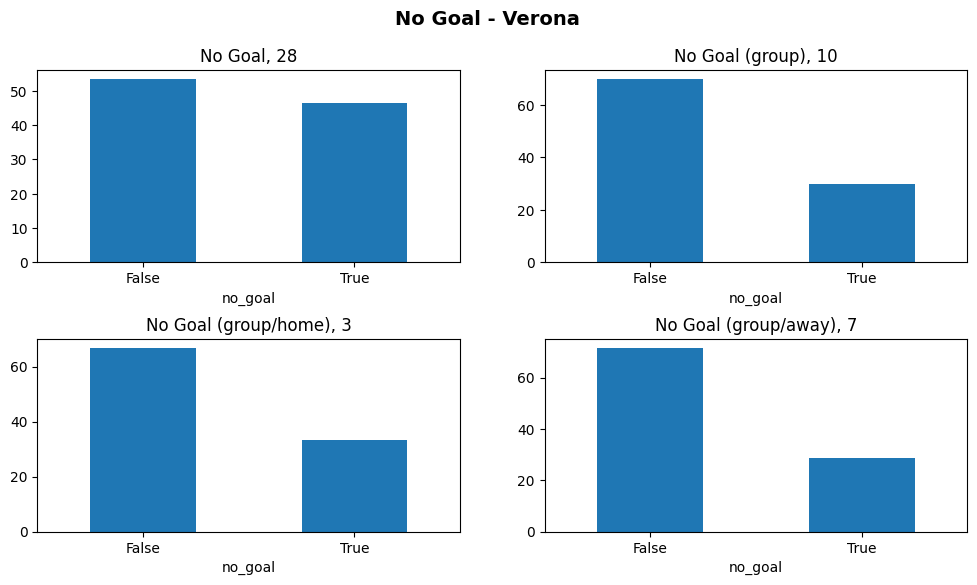

In [444]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"No Goal - {home_team}", fontsize=14, fontweight='bold')

(team_home_df.no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal, {len(team_home_df)}', ax=axes[0][0], rot=0)
(team_home_df_grp.no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group), {len(team_home_df_grp)}', ax=axes[0][1], rot=0)
(team_home_df_grp[team_home_df_grp.type=='home'].no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group/home), {len(team_home_df_grp[team_home_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_home_df_grp[team_home_df_grp.type=='away'].no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group/away), {len(team_home_df_grp[team_home_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

In [445]:
team_home_df_grp.reset_index()\
                [['main_team','opponent_team','goal_fatti','goal_subiti','giornata','type']]\
                .sort_values('giornata')

,main_team,opponent_team,goal_fatti,goal_subiti,giornata,type
6,Verona,Bologna,1,1,2.0,away
7,Verona,Empoli,1,1,4.0,away
3,Verona,Fiorentina,0,2,7.0,away
0,Verona,Udinese,1,2,8.0,home
8,Verona,Sassuolo,1,2,11.0,away
5,Verona,Monza,0,2,13.0,away
9,Verona,Torino,1,1,16.0,away
1,Verona,Udinese,1,1,20.0,away
2,Verona,Fiorentina,0,3,24.0,home
4,Verona,Monza,1,1,26.0,home


##### N° Goals

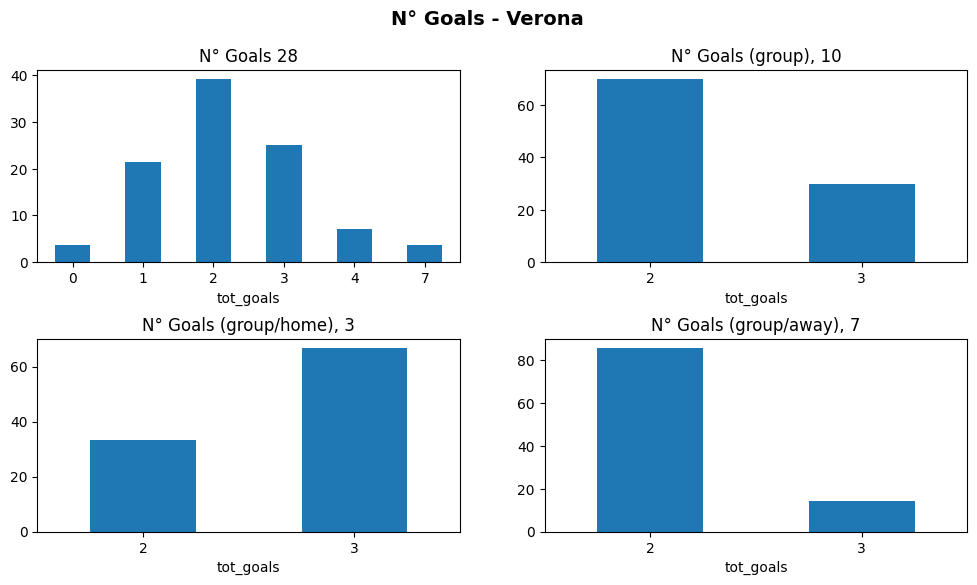

In [446]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"N° Goals - {home_team}", fontsize=14, fontweight='bold')

(team_home_df['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals {len(team_home_df)}', ax=axes[0][0], rot=0)
(team_home_df_grp['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group), {len(team_home_df_grp)}', ax=axes[0][1], rot=0)
(team_home_df_grp[team_home_df_grp.type=='home']['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group/home), {len(team_home_df_grp[team_home_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_home_df_grp[team_home_df_grp.type=='away']['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group/away), {len(team_home_df_grp[team_home_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

##### Has scored

<Axes: title={'center': 'Has scored (gpr/away), 7'}, xlabel='team_has_scored'>

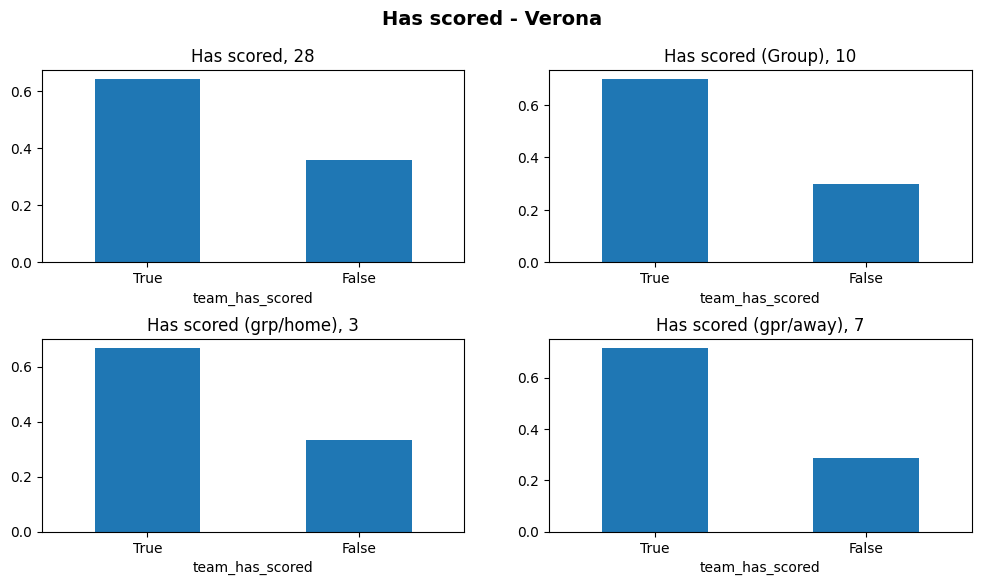

In [447]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Has scored - {home_team}", fontsize=14, fontweight='bold')

team_home_df.team_has_scored.value_counts(normalize=True).plot(kind='bar', rot=0, title=f'Has scored, {len(team_home_df)}', ax=axes[0][0])
team_home_df_grp.team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', rot=0, title=f'Has scored (Group), {len(team_home_df_grp)}', ax=axes[0][1])
team_home_df_grp[team_home_df_grp.type=='home'].team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', rot=0, title=f'Has scored (grp/home), {len(team_home_df_grp[team_home_df_grp.type=="home"])}', ax=axes[1][0])
team_home_df_grp[team_home_df_grp.type=='away'].team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', rot=0, title=f'Has scored (gpr/away), {len(team_home_df_grp[team_home_df_grp.type=="away"])}', ax=axes[1][1])


In [448]:
team_home_df_grp.head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,...,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group
4,Verona,Udinese,1,False,True,3,2,home,Loss,True,...,None,9,11,8,38,37,34,3,Udinese,1
5,Verona,Udinese,1,False,True,2,1,away,Draw,True,...,None,9,11,8,38,37,34,3,Udinese,1
19,Verona,Fiorentina,0,True,False,3,3,home,Loss,False,...,None,11,7,10,40,33,31,2,Fiorentina,1
20,Verona,Fiorentina,0,True,False,2,2,away,Loss,False,...,None,11,7,10,40,33,31,2,Fiorentina,1
21,Verona,Monza,1,False,True,2,1,home,Draw,True,...,None,9,7,12,34,32,39,-7,Monza,1


##### Has conceded goal

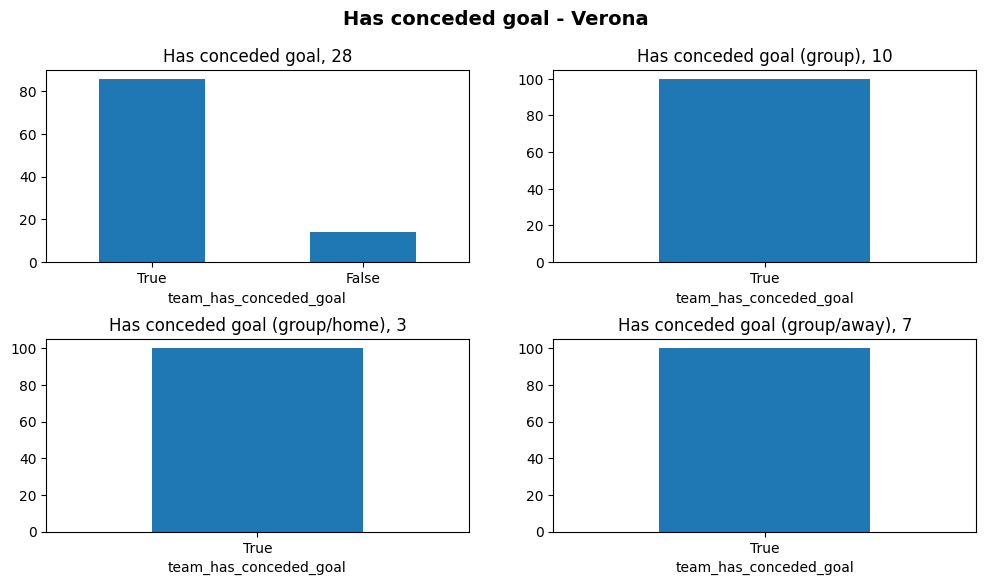

In [449]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Has conceded goal - {home_team}", fontsize=14, fontweight='bold')

(team_home_df.team_has_conceded_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Has conceded goal, {len(team_home_df)}', ax=axes[0][0], rot=0)
(team_home_df_grp.team_has_conceded_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Has conceded goal (group), {len(team_home_df_grp)}', ax=axes[0][1], rot=0)
(team_home_df_grp[team_home_df_grp.type=='home'].team_has_conceded_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Has conceded goal (group/home), {len(team_home_df_grp[team_home_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_home_df_grp[team_home_df_grp.type=='away'].team_has_conceded_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Has conceded goal (group/away), {len(team_home_df_grp[team_home_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

##### Results

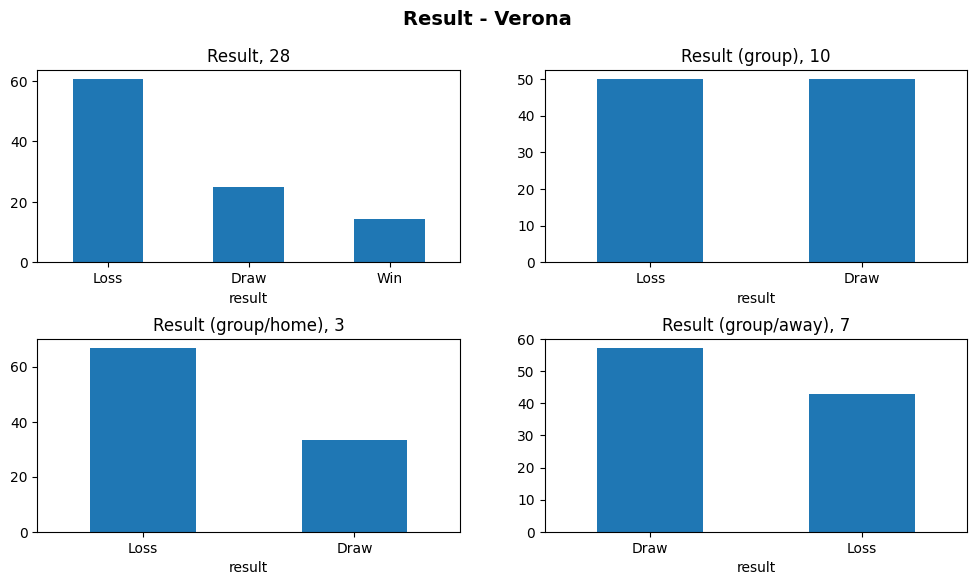

In [450]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Result - {home_team}", fontsize=14, fontweight='bold')

(team_home_df.result.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Result, {len(team_home_df)}', ax=axes[0][0], rot=0)
(team_home_df_grp.result.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Result (group), {len(team_home_df_grp)}', ax=axes[0][1], rot=0)
(team_home_df_grp[team_home_df_grp.type=='home'].result.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Result (group/home), {len(team_home_df_grp[team_home_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_home_df_grp[team_home_df_grp.type=='away'].result.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Result (group/away), {len(team_home_df_grp[team_home_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

In [451]:
team_home_df_grp.head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,...,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group
4,Verona,Udinese,1,False,True,3,2,home,Loss,True,...,None,9,11,8,38,37,34,3,Udinese,1
5,Verona,Udinese,1,False,True,2,1,away,Draw,True,...,None,9,11,8,38,37,34,3,Udinese,1
19,Verona,Fiorentina,0,True,False,3,3,home,Loss,False,...,None,11,7,10,40,33,31,2,Fiorentina,1
20,Verona,Fiorentina,0,True,False,2,2,away,Loss,False,...,None,11,7,10,40,33,31,2,Fiorentina,1
21,Verona,Monza,1,False,True,2,1,home,Draw,True,...,None,9,7,12,34,32,39,-7,Monza,1


##### Result Trend

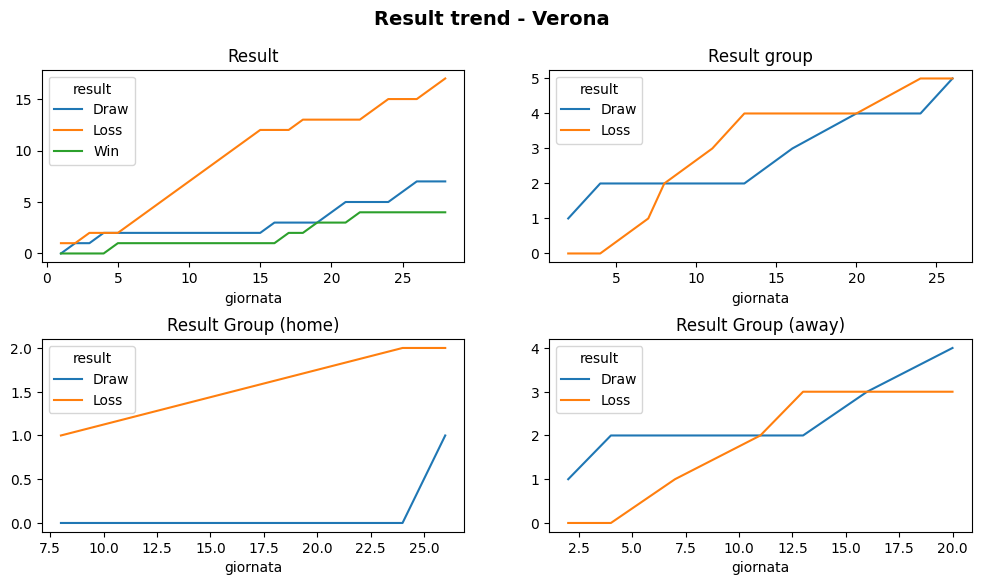

In [452]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Result trend - {home_team}", fontsize=14, fontweight='bold')

team_home_df_grp['value'] = 1
team_home_df['value'] = 1
team_home_df[['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result", ax=axes[0][0], rot=0)
team_home_df_grp[['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result group", ax=axes[0][1], rot=0)
team_home_df_grp[team_home_df_grp.type=='home'][['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result Group (home)", ax=axes[1][0], rot=0)
team_home_df_grp[team_home_df_grp.type=='away'][['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result Group (away)", ax=axes[1][1], rot=0)
plt.show()

#### Away Team

In [453]:
team_away_df = df_match[(df_match.main_team==away_team)]
team_away_df.head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal,team_has_conceded_goal
13,Sassuolo,Lecce,1,True,False,1,0,home,Win,True,2.0,No Goal,False
30,Sassuolo,Milan,0,True,False,0,0,home,Draw,False,4.0,No Goal,False
56,Sassuolo,Udinese,1,False,True,4,3,home,Loss,True,6.0,Goal,True
76,Sassuolo,Salernitana,5,True,False,5,0,home,Win,True,8.0,No Goal,False
80,Sassuolo,Inter,1,False,True,3,2,home,Loss,True,9.0,Goal,True


In [454]:
team_away_df_grp = team_away_df.merge(standing, left_on='opponent_team', right_on='team_short_name')
team_away_df_grp = team_away_df_grp[team_away_df_grp.team_group == standing[standing['team_short_name']==home_team].team_group.max()]

##### Goal/No Goal

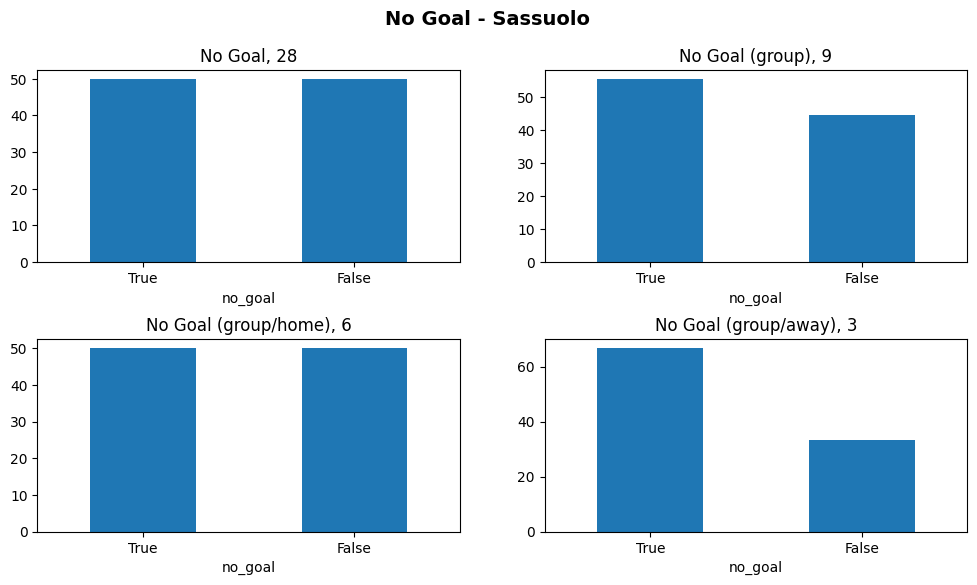

In [455]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"No Goal - {away_team}", fontsize=14, fontweight='bold')

(team_away_df.no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal, {len(team_away_df)}', ax=axes[0][0], rot=0)
(team_away_df_grp.no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group), {len(team_away_df_grp)}', ax=axes[0][1], rot=0)
(team_away_df_grp[team_away_df_grp.type=='home'].no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group/home), {len(team_away_df_grp[team_away_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_away_df_grp[team_away_df_grp.type=='away'].no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group/away), {len(team_away_df_grp[team_away_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

In [456]:
team_away_df.merge(standing, left_on='opponent_team', right_on='team_short_name').head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,...,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group
0,Sassuolo,Lecce,1,True,False,1,0,home,Win,True,...,None,6,9,13,27,24,33,-9,Lecce,2
1,Sassuolo,Lecce,1,True,False,1,0,away,Win,True,...,None,6,9,13,27,24,33,-9,Lecce,2
2,Sassuolo,Milan,0,True,False,0,0,home,Draw,False,...,None,15,6,7,51,48,36,12,Milan,0
3,Sassuolo,Milan,5,False,True,7,2,away,Win,True,...,None,15,6,7,51,48,36,12,Milan,0
4,Sassuolo,Udinese,1,False,True,4,3,home,Loss,True,...,None,9,11,8,38,37,34,3,Udinese,1


##### N° Goals

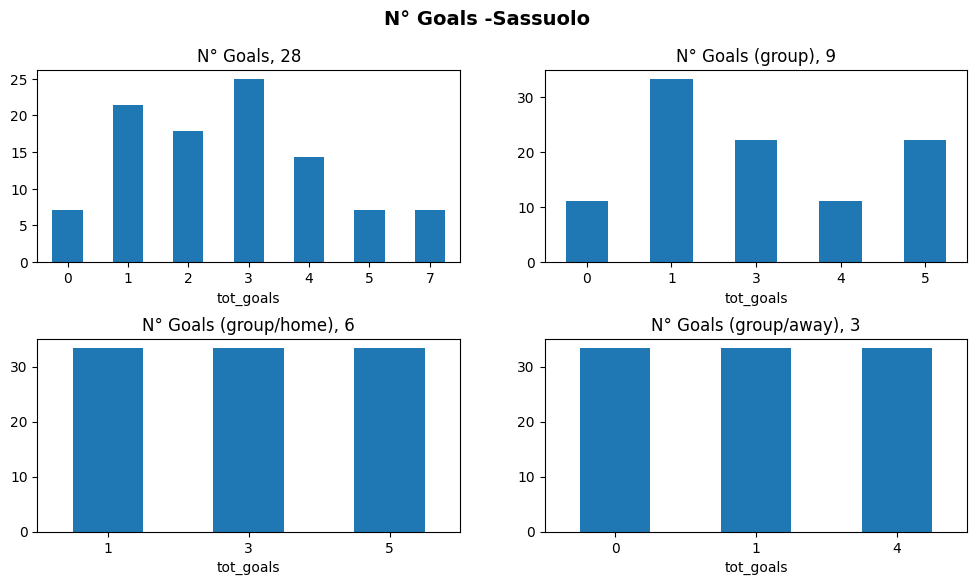

In [457]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"N° Goals -{away_team}", fontsize=14, fontweight='bold')

(team_away_df['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals, {len(team_away_df)}', ax=axes[0][0], rot=0)
(team_away_df_grp['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group), {len(team_away_df_grp)}', ax=axes[0][1], rot=0)
(team_away_df_grp[team_away_df_grp.type=='home']['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group/home), {len(team_away_df_grp[team_away_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_away_df_grp[team_away_df_grp.type=='away']['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group/away), {len(team_away_df_grp[team_away_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

##### Has Scored

<Axes: title={'center': 'Has scored (grp/away), 3'}, xlabel='team_has_scored'>

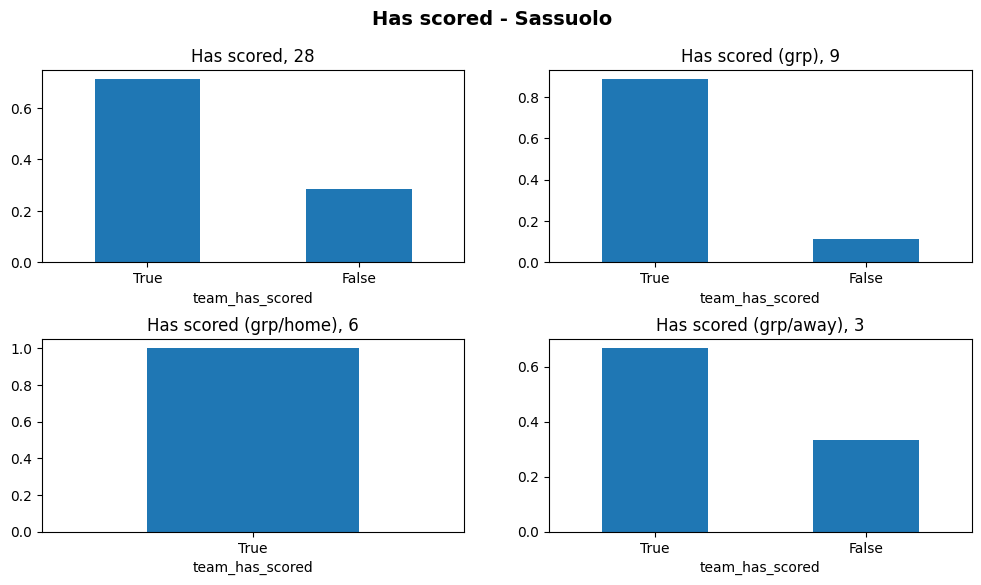

In [458]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Has scored - {away_team}", fontsize=14, fontweight='bold')

team_away_df.team_has_scored.value_counts(normalize=True).plot(kind='bar', title=f'Has scored, {len(team_away_df)}', ax=axes[0][0], rot=0)
team_away_df_grp.team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has scored (grp), {len(team_away_df_grp)}', ax=axes[0][1], rot=0)
team_away_df_grp[team_away_df_grp.type=='home'].team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has scored (grp/home), {len(team_away_df_grp[team_away_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
team_away_df_grp[team_away_df_grp.type=='away'].team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has scored (grp/away), {len(team_away_df_grp[team_away_df_grp.type=="away"])}', ax=axes[1][1], rot=0)


##### Has Conceded Goal

<Axes: title={'center': 'Has conceded goal (grp/away), 3'}, xlabel='team_has_conceded_goal'>

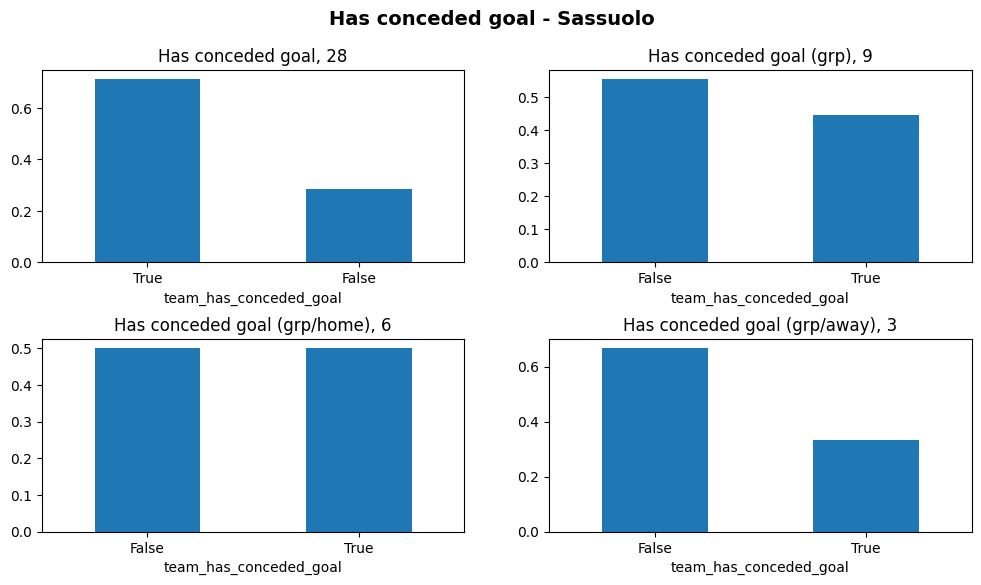

In [459]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Has conceded goal - {away_team}", fontsize=14, fontweight='bold')

team_away_df.team_has_conceded_goal.value_counts(normalize=True).plot(kind='bar', title=f'Has conceded goal, {len(team_away_df)}', ax=axes[0][0], rot=0)
team_away_df_grp.team_has_conceded_goal.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has conceded goal (grp), {len(team_away_df_grp)}', ax=axes[0][1], rot=0)
team_away_df_grp[team_away_df_grp.type=='home'].team_has_conceded_goal.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has conceded goal (grp/home), {len(team_away_df_grp[team_away_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
team_away_df_grp[team_away_df_grp.type=='away'].team_has_conceded_goal.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has conceded goal (grp/away), {len(team_away_df_grp[team_away_df_grp.type=="away"])}', ax=axes[1][1], rot=0)


##### Result

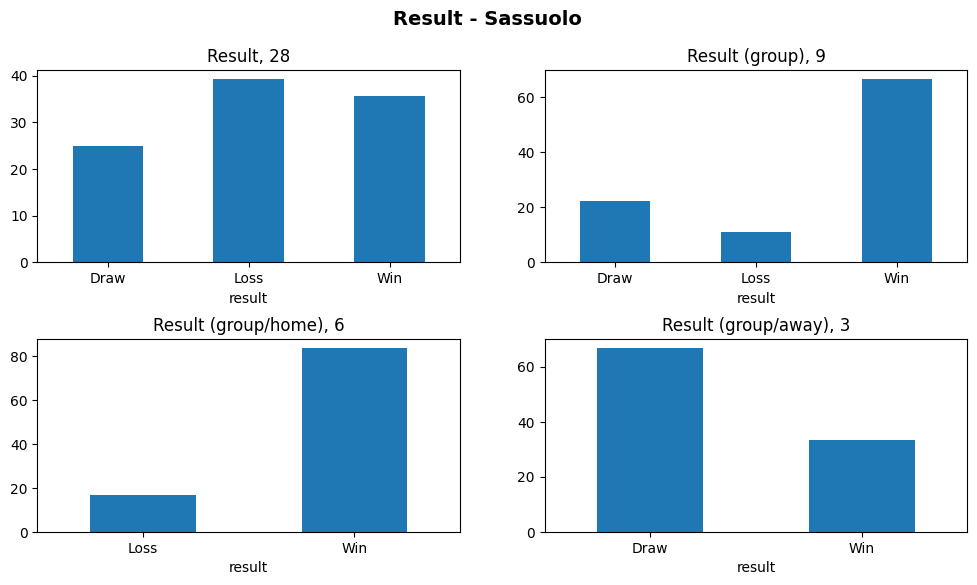

In [460]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Result - {away_team}", fontsize=14, fontweight='bold')

(team_away_df['result'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'Result, {len(team_away_df)}', ax=axes[0][0], rot=0)
(team_away_df_grp['result'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'Result (group), {len(team_away_df_grp)}', ax=axes[0][1], rot=0)
(team_away_df_grp[team_away_df_grp.type=='home']['result'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'Result (group/home), {len(team_away_df_grp[team_away_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_away_df_grp[team_away_df_grp.type=='away']['result'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'Result (group/away), {len(team_away_df_grp[team_away_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

##### Result Trend

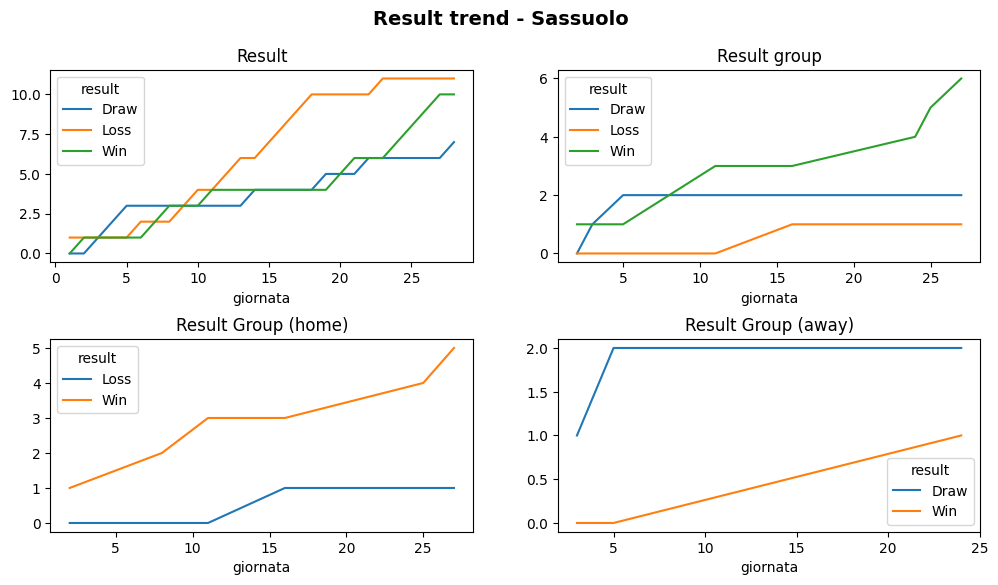

In [461]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Result trend - {away_team}", fontsize=14, fontweight='bold')

team_away_df_grp['value'] = 1
team_away_df['value'] = 1
team_away_df[['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result", ax=axes[0][0], rot=0)
team_away_df_grp[['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result group", ax=axes[0][1], rot=0)
team_away_df_grp[team_away_df_grp.type=='home'][['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result Group (home)", ax=axes[1][0], rot=0)
team_away_df_grp[team_away_df_grp.type=='away'][['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result Group (away)", ax=axes[1][1], rot=0)
plt.show()

## Analysis

### Plot number goals over giornate

<Axes: xlabel='giornata'>

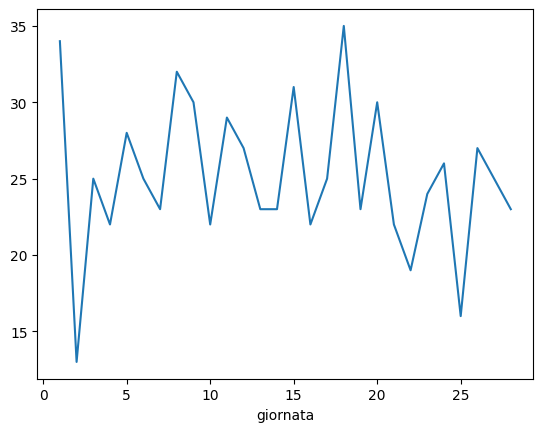

In [462]:
df[['giornata','tot_goals']].groupby(['giornata']).sum().tot_goals.plot()

### Goals distribution over matches in each giornata

In [463]:
df['row_num'] = df.groupby('giornata').cumcount()
boxgoals = df[['giornata','row_num','tot_goals']].pivot(index='row_num', columns='giornata', values='tot_goals')

<Axes: >

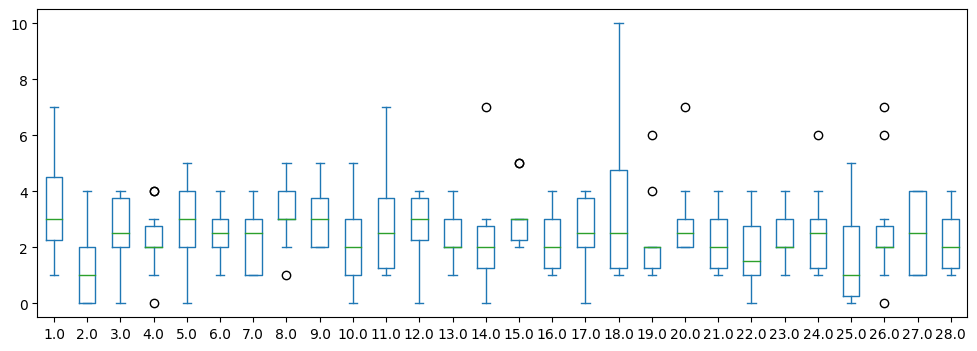

In [464]:
boxgoals.plot(kind='box', figsize=(12,4))

### Under/Over

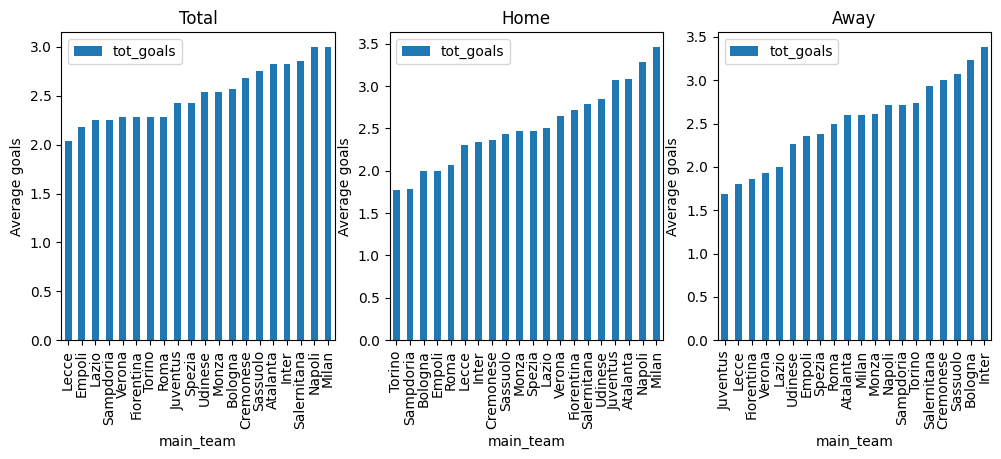

In [465]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
df_match[['main_team', 'tot_goals']].groupby('main_team').mean().sort_values('tot_goals').plot(kind='bar',  ax=ax[0])
df_match[df_match.type=='home'][['main_team', 'tot_goals']].groupby('main_team').mean().sort_values('tot_goals').plot(kind='bar',  ax=ax[1])
df_match[df_match.type=='away'][['main_team', 'tot_goals']].groupby('main_team').mean().sort_values('tot_goals').plot(kind='bar',  ax=ax[2])

ax[0].set_title('Total')
ax[1].set_title('Home')
ax[2].set_title('Away')
ax[0].set_ylabel('Average goals')
ax[1].set_ylabel('Average goals')
ax[2].set_ylabel('Average goals')

plt.show()

### Goal/No Goal

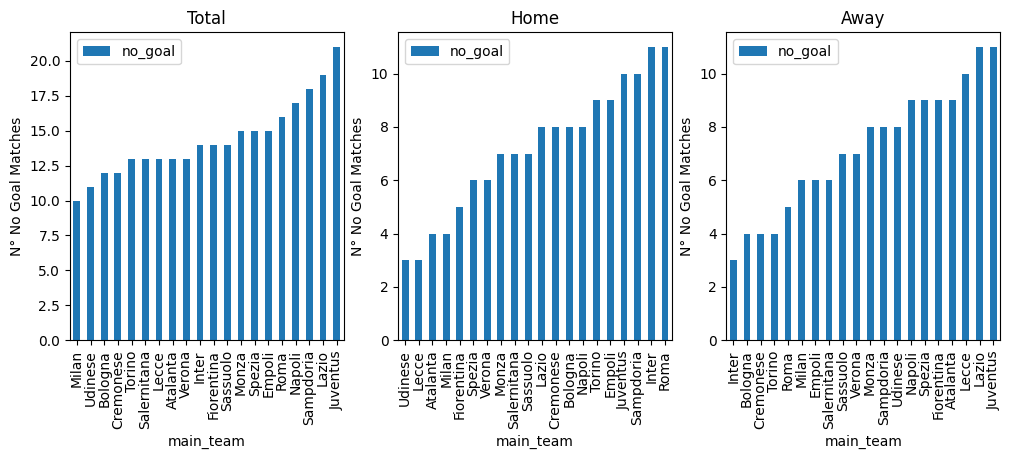

In [466]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
df_match[['main_team','no_goal']].groupby('main_team').sum().sort_values('no_goal').plot(kind='bar',  ax=ax[0])
df_match[df_match.type=='home'][['main_team','no_goal']].groupby('main_team').sum().sort_values('no_goal').plot(kind='bar',  ax=ax[1])
df_match[df_match.type=='away'][['main_team','no_goal']].groupby('main_team').sum().sort_values('no_goal').plot(kind='bar',  ax=ax[2])

ax[0].set_title('Total')
ax[1].set_title('Home')
ax[2].set_title('Away')
ax[0].set_ylabel('N° No Goal Matches')
ax[1].set_ylabel('N° No Goal Matches')
ax[2].set_ylabel('N° No Goal Matches')

plt.show()

In [467]:
df_match[(df_match.main_team == 'Real Madrid') & (df_match.type=='home')]

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal,team_has_conceded_goal


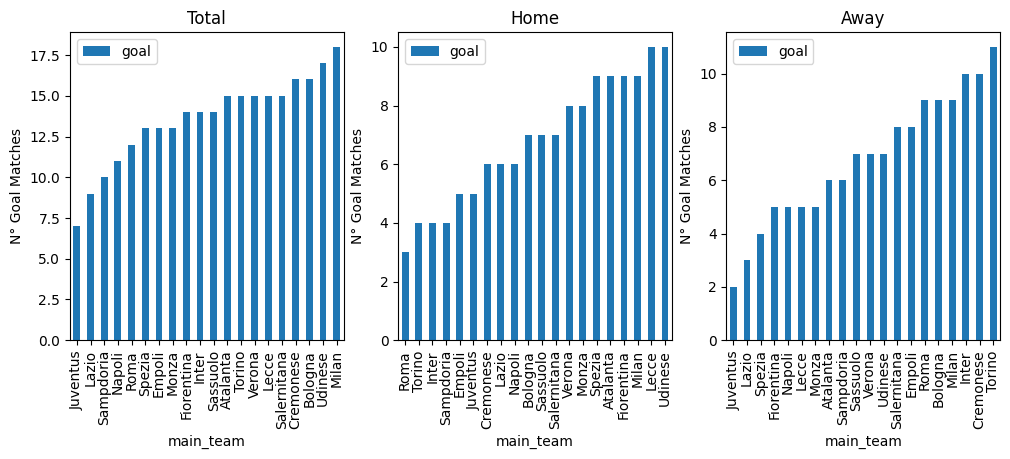

In [468]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
df_match[['main_team','goal']].groupby('main_team').sum().sort_values('goal').plot(kind='bar',  ax=ax[0])
df_match[df_match.type=='home'][['main_team','goal']].groupby('main_team').sum().sort_values('goal').plot(kind='bar',  ax=ax[1])
df_match[df_match.type=='away'][['main_team','goal']].groupby('main_team').sum().sort_values('goal').plot(kind='bar',  ax=ax[2])

ax[0].set_title('Total')
ax[1].set_title('Home')
ax[2].set_title('Away')
ax[0].set_ylabel('N° Goal Matches')
ax[1].set_ylabel('N° Goal Matches')
ax[2].set_ylabel('N° Goal Matches')

plt.show()